In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import rosen
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

In [2]:
def get_all_points(x, y):
    result = []
    for row_x in x:
        val_x = row_x[0]
        for row_y in y:
            val_y = row_y[0]
            result.append([val_x, val_y])
    return torch.tensor(result)

def get_2D_array_column(array, column: int):
    result = []
    for row in array:
        val = row[column]
        result.append([val])
    return torch.tensor(result)

@np.vectorize
def apply_function_to_meshgrid(function, X, Y):
    return function([X, Y])

In [3]:
def calculate_target_function(train_X, dtype=torch.float32, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    result = []
    for point in train_X:  # each row is a point
        val = rosen(point)
        result.append([val])

    return torch.tensor(result)

In [4]:
def BO_procedure(train_X, train_Y, bounds):
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    UCB = UpperConfidenceBound(gp, beta=10000, dtype=torch.float32)  # higher beta means more exploration (example: 10000)

    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20, dtype=torch.float32
    )

    candidate_z = calculate_target_function(candidate)
    print(f'    Candidate: ({candidate[0][0].numpy()}, {candidate[0][1].numpy()}, {candidate_z[0][0].numpy()})')

    new_X = torch.cat([train_X, candidate])
    new_Y = torch.cat([train_Y, candidate_z])

    return gp, new_X, new_Y

In [5]:
def plot(model, train_X, train_Y, bounds):
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    %matplotlib inline

    target_x = torch.linspace(bounds[0][0], bounds[1][0], 31).unsqueeze(1)
    target_y = torch.linspace(bounds[0][1], bounds[1][1], 31).unsqueeze(1)
    target_xy = get_all_points(target_x, target_y)
    target_z = calculate_target_function(target_xy)

    # # Initialize plot
    fig, ax = plt.subplots(1, 2)

    # # no need for gradients
    with torch.no_grad():

        # plot target function (inclusion of noise decreases accuracy)
        X, Y = np.meshgrid(torch.linspace(bounds[0][0], bounds[1][0], 31), torch.linspace(bounds[0][1], bounds[1][1], 31))
        Z = apply_function_to_meshgrid(rosen, X, Y)
        levels = np.linspace(Z.min(), Z.max(), 25)
        ax[0].contourf(X, Y, Z, levels=levels)

        # compute posterior
        posterior = model.posterior(target_xy)
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        pnt_x, pnt_y = get_2D_array_column(train_X, 0), get_2D_array_column(train_X, 1)
        ax[0].scatter(pnt_x, pnt_y, train_Y, color='k')
        # Plot posterior means as blue line
        posterior_mean = posterior.mean.cpu().numpy()
        levels = np.linspace(posterior_mean.min(), posterior_mean.max(), 25)
        ax[1].contourf(X, Y, posterior_mean.reshape(X.shape, order='F'), levels=levels)  # Fortran-like index order matches graph orientation

    plt.tight_layout()

Iteration 1:
    Candidate: (0.9360493421554565, 0.5558731555938721, 10.264274597167969)
Iteration 2:
    Candidate: (0.9749562740325928, 0.9797462224960327, 0.08592923730611801)
Iteration 3:
    Candidate: (-1.0, 0.6313441395759583, 17.590713500976562)
Iteration 4:
    Candidate: (-0.8877032399177551, -1.0, 323.263916015625)
Iteration 5:
    Candidate: (1.0, -1.0, 400.0)
Iteration 6:
    Candidate: (0.34435707330703735, -1.0, 125.5523910522461)
Iteration 7:
    Candidate: (-0.629160463809967, -0.049116671085357666, 22.45306396484375)
Iteration 8:
    Candidate: (1.0, -0.4621604382991791, 213.79132080078125)
Iteration 9:
    Candidate: (0.3744370937347412, 0.5313173532485962, 15.688363075256348)
Iteration 10:
    Candidate: (-0.33273550868034363, -1.0, 125.14449310302734)
Iteration 11:
    Candidate: (-0.988683819770813, -1.0, 395.0037841796875)
Iteration 12:
    Candidate: (0.7153446674346924, -1.0, 228.61016845703125)
Iteration 13:
    Candidate: (-1.0, -0.8679846525192261, 352.93667

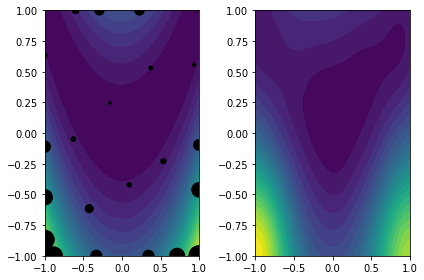

In [6]:
# use a GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = dtype=torch.float32
NUM_ITERATIONS = 25
BOUNDS = torch.tensor([[-1.0, -1.0], [1.0, 1.0]])

x = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 1, dtype=DTYPE, device=DEVICE).unsqueeze(1)
y = torch.linspace(BOUNDS[0][1], BOUNDS[1][1], 1, dtype=DTYPE, device=DEVICE).unsqueeze(1)
train_XY = get_all_points(x, y)
train_Z = calculate_target_function(train_XY)

for i in range(NUM_ITERATIONS):
    print(f'Iteration {i + 1}:')
    model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)

plot(model, train_XY, train_Z, BOUNDS)

    Candidate: (0.01999448426067829, -1.0, 101.04039001464844)


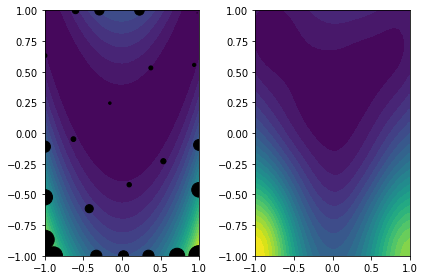

In [7]:
model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)
plot(model, train_XY, train_Z, BOUNDS)

    Candidate: (0.5973044633865356, 1.0, 41.53630447387695)


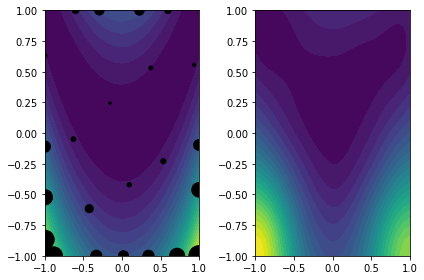

In [8]:
model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)
plot(model, train_XY, train_Z, BOUNDS)

    Candidate: (-0.535216748714447, 0.4325212240219116, 4.4903669357299805)


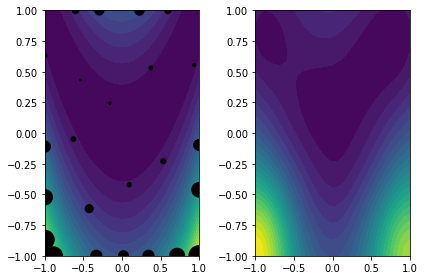

In [9]:
model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)
plot(model, train_XY, train_Z, BOUNDS)

    Candidate: (0.22790367901325226, 0.09181041270494461, 0.7550970315933228)


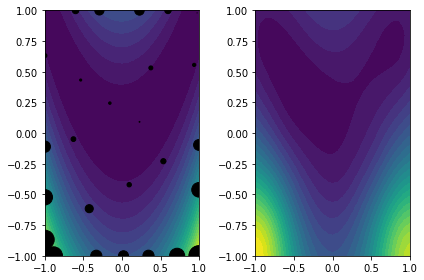

In [10]:
model, train_XY, train_Z = BO_procedure(train_XY, train_Z, BOUNDS)
plot(model, train_XY, train_Z, BOUNDS)